In [1]:
import torch
import umap
import numpy as np
import pandas as pd
import plotly.express as px
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from IPython import display

In [2]:
# MNIST is 28x28 (784)
input_w = 28
input_h = 28
input_dim = input_w * input_h
hidden_dim_1 = 512
hidden_dim_2 = 512
hidden_dim_3 = 256
latent_dim = 128

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class VAE(nn.Module):
    def __init__(self, hidden_dim_1, hidden_dim_2, hidden_dim_3, latent_dim, input_dim):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_3),
            nn.ReLU(),
            nn.Linear(hidden_dim_3, hidden_dim_3),
            nn.ReLU(),
        )
        self.fc_mean = nn.Linear(hidden_dim_3, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim_3, latent_dim)
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim_3),
            nn.ReLU(),
            nn.Linear(hidden_dim_3, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, input_dim),
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mean, logvar = self.encode(x.view(-1, input_dim))
        z = self.reparameterize(mean, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mean, logvar

In [5]:
def loss_function(reconstructed_x, x, mean, logvar):
    BCE = F.binary_cross_entropy_with_logits(reconstructed_x, x.view(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KLD

In [6]:
# Transform to normalize data to [0, 1]
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [7]:
model = VAE(hidden_dim_1=hidden_dim_1, hidden_dim_2=hidden_dim_2, hidden_dim_3=hidden_dim_3, latent_dim=latent_dim, input_dim=input_dim).to(device)
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
  )
  (fc_mean): Linear(in_features=256, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [8]:
def plot_random_samples(width, height, figsize):
    """Generate random samples and plot them."""
    with torch.no_grad():
        z = torch.randn(width*height, latent_dim).to(device)
        sample = model.decode(z)
        sample = torch.sigmoid(sample)  # Convert logits to probabilities

    fig, axes = plt.subplots(width, height, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(sample[i].cpu().view(input_w, input_h), cmap='gray')
        ax.axis('off')
    plt.show()

In [9]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed_batch, mean, logvar = model(data)
        
        # Compute loss
        loss = loss_function(reconstructed_batch, data, mean, logvar)
        
        # Backward pass and optimize
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    # Print average loss per epoch
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

Epoch 1/10, Loss: 198.8626
Epoch 2/10, Loss: 159.0896
Epoch 3/10, Loss: 143.0622
Epoch 4/10, Loss: 136.7910
Epoch 5/10, Loss: 130.9195
Epoch 6/10, Loss: 127.5514
Epoch 7/10, Loss: 125.4757
Epoch 8/10, Loss: 123.7523
Epoch 9/10, Loss: 122.2481
Epoch 10/10, Loss: 119.8365


In [14]:
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
  )
  (fc_mean): Linear(in_features=256, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [15]:
def plot_latent_space_umap(model, data_loader, device):
    model.eval()
    latent_means = []
    labels = []
    
    with torch.no_grad():
        for data in data_loader:
            img, label = data
            img = img.view(img.size(0), -1).to(device)
            _, mean, logvar = model(img)
            latent_means.append(mean.cpu())
            labels.append(label)
    
    latent_means = torch.cat(latent_means, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # Use UMAP instead of PCA
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=20,       # Controls local vs global structure
        min_dist=0.1,         # Controls cluster tightness
        metric='euclidean',   # Distance metric
        random_state=42
    )
    latent_2d = reducer.fit_transform(latent_means)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.8) #cmap='tab10', alpha=0.6)
    plt.colorbar()
    plt.title('Latent Space Visualization (UMAP)')
    plt.show()

    return latent_means, labels

/home/ebljohn/github/setup_notebook_server/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ebljohn/github/setup_notebook_server/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


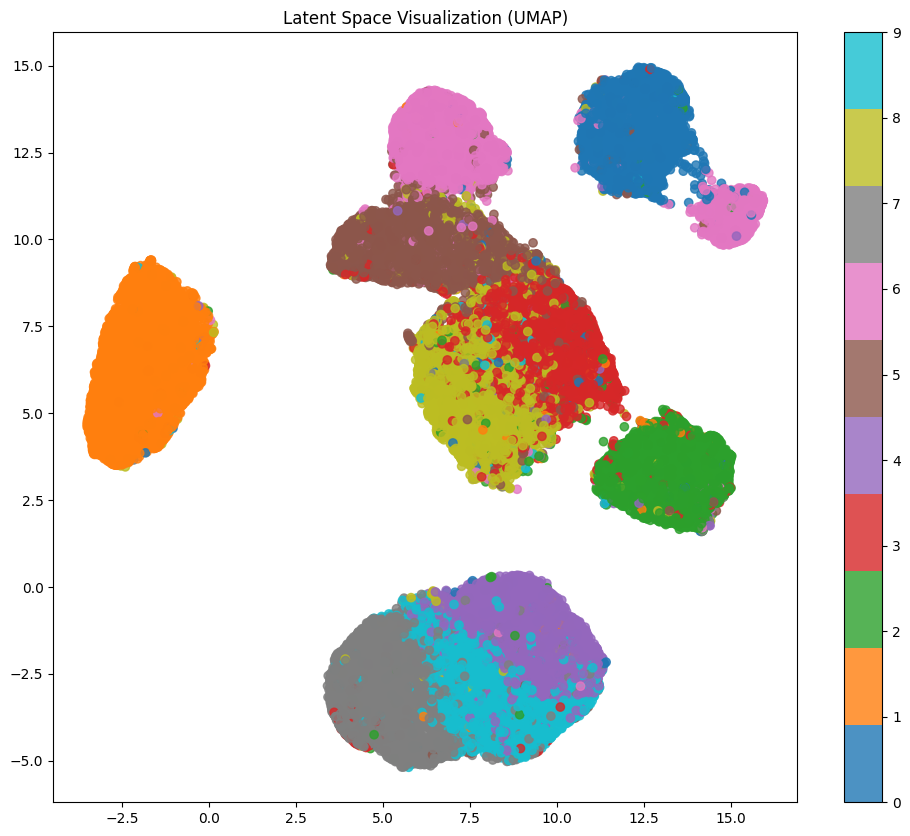

In [16]:
# Plot latent space using UMAP
latents, labels = plot_latent_space_umap(model, train_loader, device)

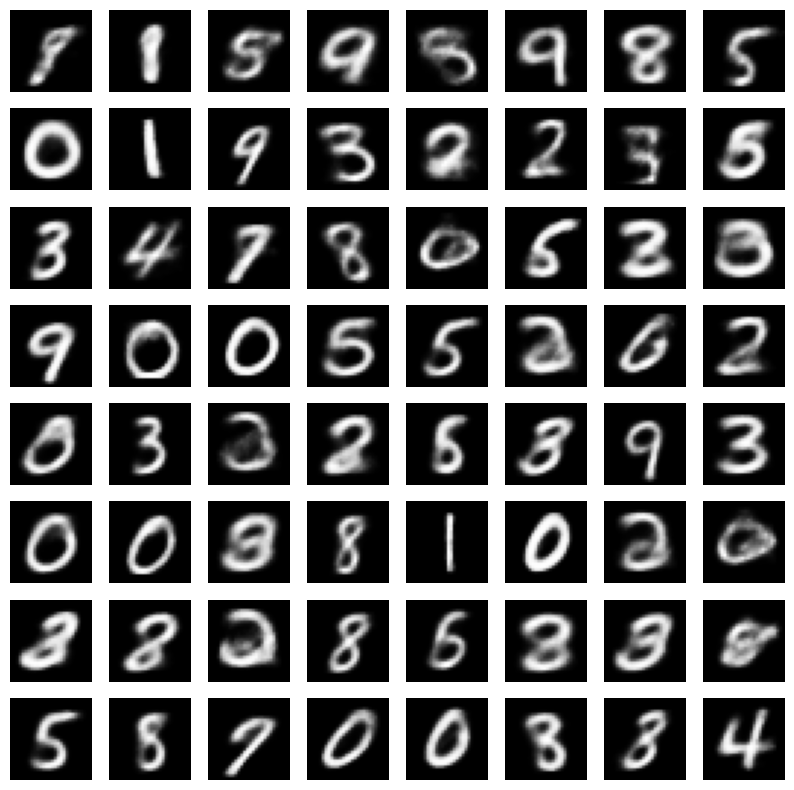

In [17]:
plot_random_samples(8, 8, figsize=(10,10))

In [20]:
def find_digit(num, data_loader):
    with torch.no_grad():
        for data in data_loader:
            imgs, labels = data
            matches = (labels == num).nonzero()
            if len(matches) > 0:
                idx = matches[0].item()
                return imgs[idx]

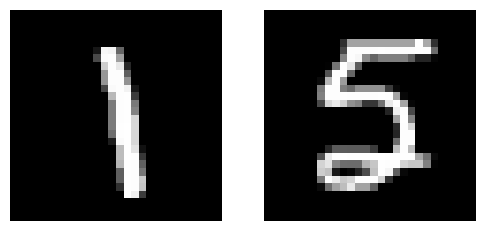

In [21]:
img_source = find_digit(1, train_loader)
img_target = find_digit(5, train_loader)

fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].imshow(img_source.view(28, 28), cmap='gray')
axes[0].axis('off')
axes[1].imshow(img_target.view(28, 28), cmap='gray')
axes[1].axis('off')
plt.show()

In [22]:
def digit_to_latent_space(img):
    with torch.no_grad():
        model.eval()
        mean, logvar = model.encode(img.view(1, 784))
        z = model.reparameterize(mean, logvar)
        return z

In [23]:
def latent_space_to_digit(z):
    with torch.no_grad():
        sample = model.decode(z)
        sample = torch.sigmoid(sample) # Convert logits to probabilities
        return sample

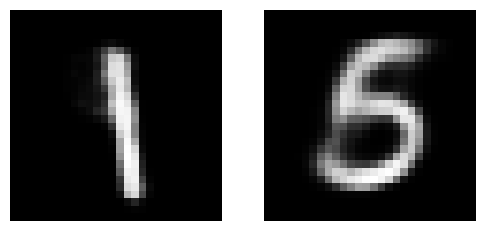

In [24]:
z_source = digit_to_latent_space(img_source)
z_target = digit_to_latent_space(img_target)

sampled_source = latent_space_to_digit(z_source).cpu().detach().view(28, 28)
sampled_target = latent_space_to_digit(z_target).cpu().detach().view(28, 28)

fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].imshow(sampled_source.view(28, 28), cmap='gray')
axes[0].axis('off')
axes[1].imshow(sampled_target.view(28, 28), cmap='gray')
axes[1].axis('off')
plt.show()

In [25]:
from ipywidgets import interact, FloatSlider

@interact(alpha=FloatSlider(min=0, max=1, step=0.01, value=0))
def show_morph(alpha):
    with torch.no_grad():
        z = (1 - alpha) * z_source + alpha * z_target
        sample = torch.sigmoid(model.decode(z)).cpu().detach().view(28, 28)
        plt.figure(figsize=(3, 3))
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        plt.show()

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

In [26]:
def sample_around_z(z_original, num_samples=4, epsilon=1.0):
    """Generate samples around a latent vector `z_original`."""
    perturbed_zs = []
    
    for _ in range(num_samples):
        # Generate a random direction and normalize it
        direction = torch.randn_like(z_original)
        direction = direction / torch.norm(direction)
        
        # Perturb the original vector
        z_perturbed = z_original + epsilon * direction
        perturbed_zs.append(z_perturbed)
    
    # Decode all latent vectors
    with torch.no_grad():
        samples = [torch.sigmoid(model.decode(z)) for z in perturbed_zs]

    return samples

In [27]:
from ipywidgets import interact, FloatSlider

img_source = find_digit(5, train_loader)
z_source = digit_to_latent_space(img_source)
direction = torch.randn_like(z_source)
direction = direction / torch.norm(direction)

@interact(epsilon=FloatSlider(min=0, max=10, step=0.01, value=0))
def show_morph_dir(epsilon):
    with torch.no_grad():
        z = z_source + epsilon * direction
        sample = torch.sigmoid(model.decode(z)).cpu().detach().view(28, 28)
        fig, axes = plt.subplots(1, 2, figsize=(6, 6))
        axes[0].imshow(img_source.squeeze(), cmap='gray') 
        axes[0].axis('off')
        axes[1].imshow(sample, cmap='gray')
        axes[1].axis('off')
        plt.show()

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=10.0, step=0.01), Output()), _dom_clas…

In [32]:
z_random = torch.randn(1, latent_dim).to(device)
img_target = find_digit(5, train_loader)
z_target = digit_to_latent_space(img_target)

@interact(alpha=FloatSlider(min=0, max=1, step=0.01, value=0))
def show_morph(alpha):
    with torch.no_grad():
        z = (1 - alpha) * z_random + alpha * z_target
        sample = torch.sigmoid(model.decode(z)).cpu().detach().view(28, 28)
        fig, axes = plt.subplots(1, 2, figsize=(6, 6))
        axes[0].imshow(sample.view(28, 28), cmap='gray')
        axes[0].axis('off')
        axes[1].imshow(img_target.view(28, 28), cmap='gray')
        axes[1].axis('off')
        plt.show()

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…